<img src="http://naonedia.fr/wp-content/uploads/2018/10/logoNaonedia.png" style="height:100px">
<h1>
    <center>Expérience Logement</center>
    <center>-</center>
    <center>Analyse des modèles</center>
</h1>


<h3> Introduction </h3>

Le but de ce notebook est d'analyser les différents modèles. Le but est de regarder les résultats en prédiction et généralisation. On peut ainsi caractériser un modèle et déterminer si il est satisfaisant ou non.

<h3>Informations</h3>

Il est fortement conseillé d'utiliser Python3.x
Si vous ne disposez pas de toutes les librairies requises , il suffit de l'installer en utilisant la commande suivante.
<br>
<code>pip3 install ....</code>

<h3>Authors:</h3>
<cite>Thibault Brocherieux - Ippon Technologies</cite>

### Import des librairies requises

In [85]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import keras
from sklearn.metrics import median_absolute_error, mean_absolute_error
import pandas as pd
import json

plt.rcParams['figure.figsize'] = [25, 10]

### Fonctions pour l'affichage des graphiques

In [103]:
py.init_notebook_mode(connected=True)

def py_table(data, filename):
    table = ff.create_table(data)
    py.iplot(table, filename=filename)

def py_pie(values, title, filename, labels=None):
    if labels is None:
        labels = values.index
        values = values.values
    pie = go.Pie(labels=labels, values=values, title=title)
    
    
    layout = go.Layout(legend=dict(orientation="h"))

    fig = go.Figure(data=[pie], layout=layout)
    
    py.iplot(fig,filename=filename)

def py_pie_compare(values_1, values_2, name_1, name_2, title, filename, labels_1=None, labels_2=None):

    if labels_1 is None:
        labels_1 = values_1.index
        values_1 = values_1.values
    
    if labels_2 is None:
        labels_2 = values_2.index
        values_2 = values_2.values

    pie_1 = go.Pie(labels=labels_1, values=values_1, title=name_1 + ' ' + title,domain=dict(x=[0, 0.4])),
    pie_2 = go.Pie(labels=labels_2, values=values_2, title=name_2 + ' ' + title,domain=dict(x=[0.6, 1])),
    
    layout = go.Layout(legend=dict(orientation="h"))

    fig = go.Figure(data=[pie_1[0], pie_2[0]], layout=layout)
    
    py.iplot(fig,filename=filename)
    
def loadHistoryFile(file):
    res = {}
    with open(file) as json_data:
        res = json.load(json_data)
    return res

def plotHistory(train, test, text):
    plt.plot(train)
    plt.plot(test)
    plt.title('model ' + text)
    plt.ylabel(text)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plotHistoryCompare(train_1, test_1, train_2, test_2, text, name_1, name_2):
    plt.subplot(121)
    plt.plot(train_1)
    plt.plot(test_1)
    plt.title(name_1 + ' ' + text)
    plt.ylabel(text)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(122)
    plt.plot(train_2)
    plt.plot(test_2)
    plt.title(name_2 + ' ' + text)
    plt.ylabel(text)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

### Fonction pour le traitement des données

In [10]:
def normalize(x_train, x_test):
    mu = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    x_train_normalized = (x_train - mu) / std
    x_test_normalized = (x_test - mu) / std
    return x_train_normalized, x_test_normalized

### Chargement des données

In [11]:
# Chargement des données d'entrainement et de test
data_train = pd.read_csv('data/models/modelv2.train.csv')
data_test = pd.read_csv('data/models/modelv2.test.csv')

X_train = data_train.drop(['valeur_fonciere'], axis=1).to_numpy()
y_train = data_train['valeur_fonciere'].to_numpy()
X_test = data_test.drop(['valeur_fonciere'], axis=1).to_numpy()
y_test = data_test['valeur_fonciere'].to_numpy()

# Datasets normalisés
X_train_normal, X_test_normal = normalize(X_train, X_test)

# load model
model = load_model("data/models/modelv2.h5")

# load history
history = loadHistoryFile('data/models/modelv2.history.json')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Evaluate part of generalisation

In [39]:
def checkResponse(model, index):
    print("Real price %s €, predicted %s €" % (model.predict(np.array([X_test_normal[index]]))[0][0], y_test[index]))
    
def retrieveWrong(predict, real):
    res = []
    ref = median_absolute_error(real, predict)
    for index,val in enumerate(predict):
        tmp = abs(val - real[index])[0]
        if tmp > ref:
            res.append(tmp)
            
    return res

def retrieveTenKGroup(predict, real):
    res = []
    ref = median_absolute_error(real, predict)
    for index,val in enumerate(predict):
        tmp = abs(val - real[index])[0]
        res.append(str(int(tmp // 10000 * 10000)) + 'k')

    return pd.DataFrame({'data':np.array(res)})

def retrieveTenKGroup2(predict, real):
    res = []
    ref = median_absolute_error(real, predict)
    for index,val in enumerate(predict):
        tmp = abs(val - real[index])[0]
        tmp2 = int(tmp // 10000 * 10000)
        if tmp2 > 30000:
            res.append('Autres')
        else:
            res.append(str(tmp2) + 'k')

    return pd.DataFrame({'data':np.array(res)})

In [105]:
def globalAnalysis(name):
    # Chargement des données d'entrainement et de test
    data_train = pd.read_csv('data/models/'+ name +'.train.csv')
    data_test = pd.read_csv('data/models/'+ name +'.test.csv')

    X_train = data_train.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_train = data_train['valeur_fonciere'].to_numpy()
    X_test = data_test.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_test = data_test['valeur_fonciere'].to_numpy()

    # Datasets normalisés
    X_train_normal, X_test_normal = normalize(X_train, X_test)

    # load model
    model = load_model('data/models/'+ name +'.h5')

    # load history
    history = loadHistoryFile('data/models/'+ name +'.history.json')
    
    model.summary()
    
    plotHistory(history['loss'],history['val_loss'], 'accuracy')
    plotHistory(history['mean_squared_error'],history['val_mean_squared_error'], 'mean_squared_error')
    plotHistory(history['mean_absolute_error'],history['val_mean_absolute_error'], 'mean_absolute_error')
    print('Median absolute error train: ' + str(median_absolute_error(y_train, model.predict(X_train_normal))))
    print('Median absolute error train: ' + str(median_absolute_error(y_test, model.predict(X_test_normal))))
    print('Mean absolute error train: ' + str(mean_absolute_error(y_train, model.predict(X_train_normal))))
    print('Mean absolute error train: ' + str(mean_absolute_error(y_test, model.predict(X_test_normal))))
    
    py_pie(retrieveTenKGroup2(model.predict(X_train_normal),y_train)['data'].value_counts(),
       'Écart de prédiction regroupé par tranches de 10 000€ ',
       'ecart10k')
    
    py_pie(retrieveTenKGroup2(model.predict(X_test_normal),y_test)['data'].value_counts(),
       'Écart de généralisation regroupé par tranches de 10 000€ ',
       'ecart10k')
    
def compareTwoModel(name1, name2):
    
    ################################################################################
    # Model 1
    ################################################################################
    
    # Chargement des données d'entrainement et de test
    data_train = pd.read_csv('data/models/'+ name1 +'.train.csv')
    data_test = pd.read_csv('data/models/'+ name1 +'.test.csv')

    X_train = data_train.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_train_1 = data_train['valeur_fonciere'].to_numpy()
    X_test = data_test.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_test_1 = data_test['valeur_fonciere'].to_numpy()

    # Datasets normalisés
    X_train_normal_1, X_test_normal_1 = normalize(X_train, X_test)

    # load model
    model_1 = load_model('data/models/'+ name1 +'.h5')

    # load history
    history_1 = loadHistoryFile('data/models/'+ name1 +'.history.json')
    
    ################################################################################
    # Model 2
    ################################################################################

        # Chargement des données d'entrainement et de test
    data_train = pd.read_csv('data/models/'+ name2 +'.train.csv')
    data_test = pd.read_csv('data/models/'+ name2 +'.test.csv')

    X_train = data_train.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_train_2 = data_train['valeur_fonciere'].to_numpy()
    X_test = data_test.drop(['valeur_fonciere'], axis=1).to_numpy()
    y_test_2 = data_test['valeur_fonciere'].to_numpy()

    # Datasets normalisés
    X_train_normal_2, X_test_normal_2 = normalize(X_train, X_test)

    # load model
    model_2 = load_model('data/models/'+ name2 +'.h5')

    # load history
    history_2 = loadHistoryFile('data/models/'+ name2 +'.history.json')
    
    ################################################################################
    # Compare model
    ################################################################################
    
    plotHistoryCompare(
        history_1['loss'],
        history_1['val_loss'],
        history_2['loss'],
        history_2['val_loss'],
        'accuracy',
        name1,
        name2
    )

    plotHistoryCompare(
        history_1['mean_squared_error'],
        history_1['val_mean_squared_error'],
        history_2['mean_squared_error'],
        history_2['val_mean_squared_error'],
        'mean_squared_error',
        name1,
        name2
    )
    
    plotHistoryCompare(
        history_1['mean_absolute_error'],
        history_1['val_mean_absolute_error'], 
        history_2['mean_absolute_error'],
        history_2['val_mean_absolute_error'], 
        'mean_absolute_error',
        name1,
        name2
    )
    
    print('Median absolute error train: ')
    print('{} {}'.format(name1, median_absolute_error(y_train_1, model_1.predict(X_train_normal_1))))
    print('{} {}'.format(name2, median_absolute_error(y_train_2, model_2.predict(X_train_normal_2))))

    print('Median absolute error test: ')
    print('{} {}'.format(name1, median_absolute_error(y_test_1, model_1.predict(X_test_normal_1))))
    print('{} {}'.format(name2, median_absolute_error(y_test_2, model_2.predict(X_test_normal_2))))

    
    
    print('Mean absolute error train: ')
    print('{} {}'.format(name1, mean_absolute_error(y_train_1, model_1.predict(X_train_normal_1))))
    print('{} {}'.format(name2, mean_absolute_error(y_train_2, model_2.predict(X_train_normal_2))))

    print('Mean absolute error test: ')
    print('{} {}'.format(name1, mean_absolute_error(y_test_1, model_1.predict(X_test_normal_1))))
    print('{} {}'.format(name2, mean_absolute_error(y_test_2, model_2.predict(X_test_normal_2))))

    
    py_pie_compare(
        retrieveTenKGroup2(model_1.predict(X_train_normal_1),y_train_1)['data'].value_counts(),
        retrieveTenKGroup2(model_2.predict(X_train_normal_2),y_train_2)['data'].value_counts(),
        name1,
        name2,
       'Écart de prédiction regroupé par tranches de 10 000€ ',
       'ecart10k')
    
    py_pie_compare(
        retrieveTenKGroup2(model_1.predict(X_test_normal_1),y_test_1)['data'].value_counts(),
        retrieveTenKGroup2(model_2.predict(X_test_normal_2),y_test_2)['data'].value_counts(),
        name1,
        name2,
       'Écart de généralisation regroupé par tranches de 10 000€ ',
       'ecart10k')
    

## Analyse du modèle

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               56320     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

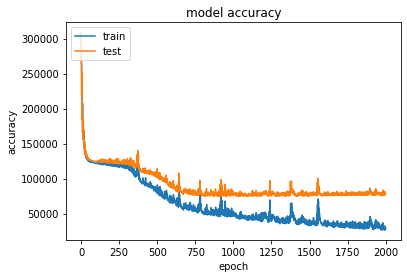

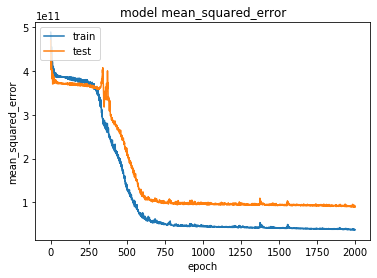

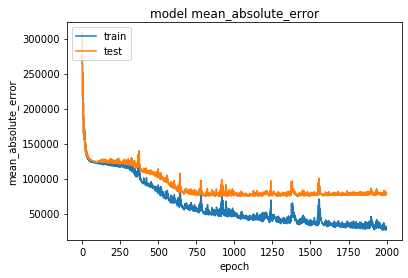

Median absolute error train: 14336.34375
Median absolute error train: 36454.1796875
Mean absolute error train: 31097.962719818956
Mean absolute error train: 77961.95670731626


In [43]:
globalAnalysis('modelv2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               56320     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

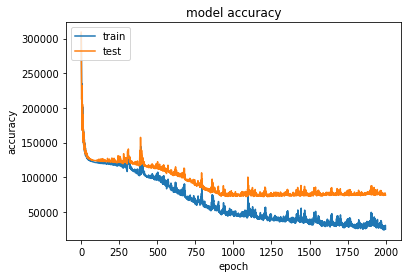

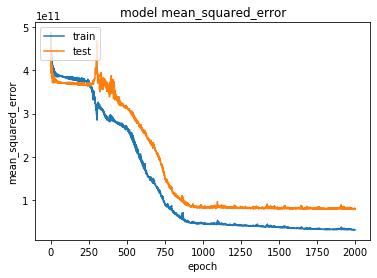

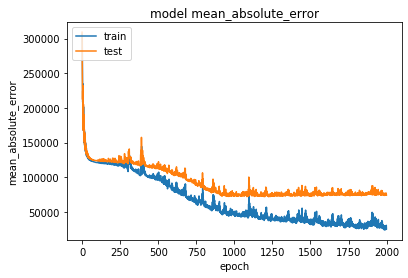

Median absolute error train: 11763.34375
Median absolute error train: 35326.359375
Mean absolute error train: 26835.89396834349
Mean absolute error train: 74576.51077524298


In [55]:
globalAnalysis('modelv5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               112640    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
__________

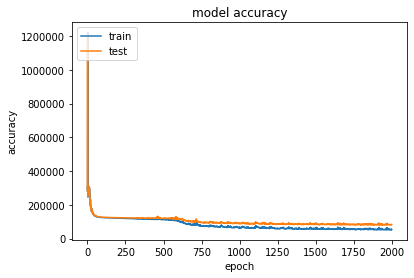

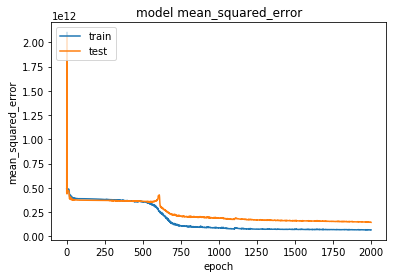

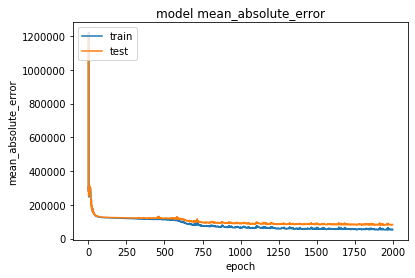

Median absolute error train: 21646.078125
Median absolute error train: 32681.00390625
Mean absolute error train: 53162.083857375976
Mean absolute error train: 82649.63648234871


In [26]:
globalAnalysis('modelv3')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               56320     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
__________

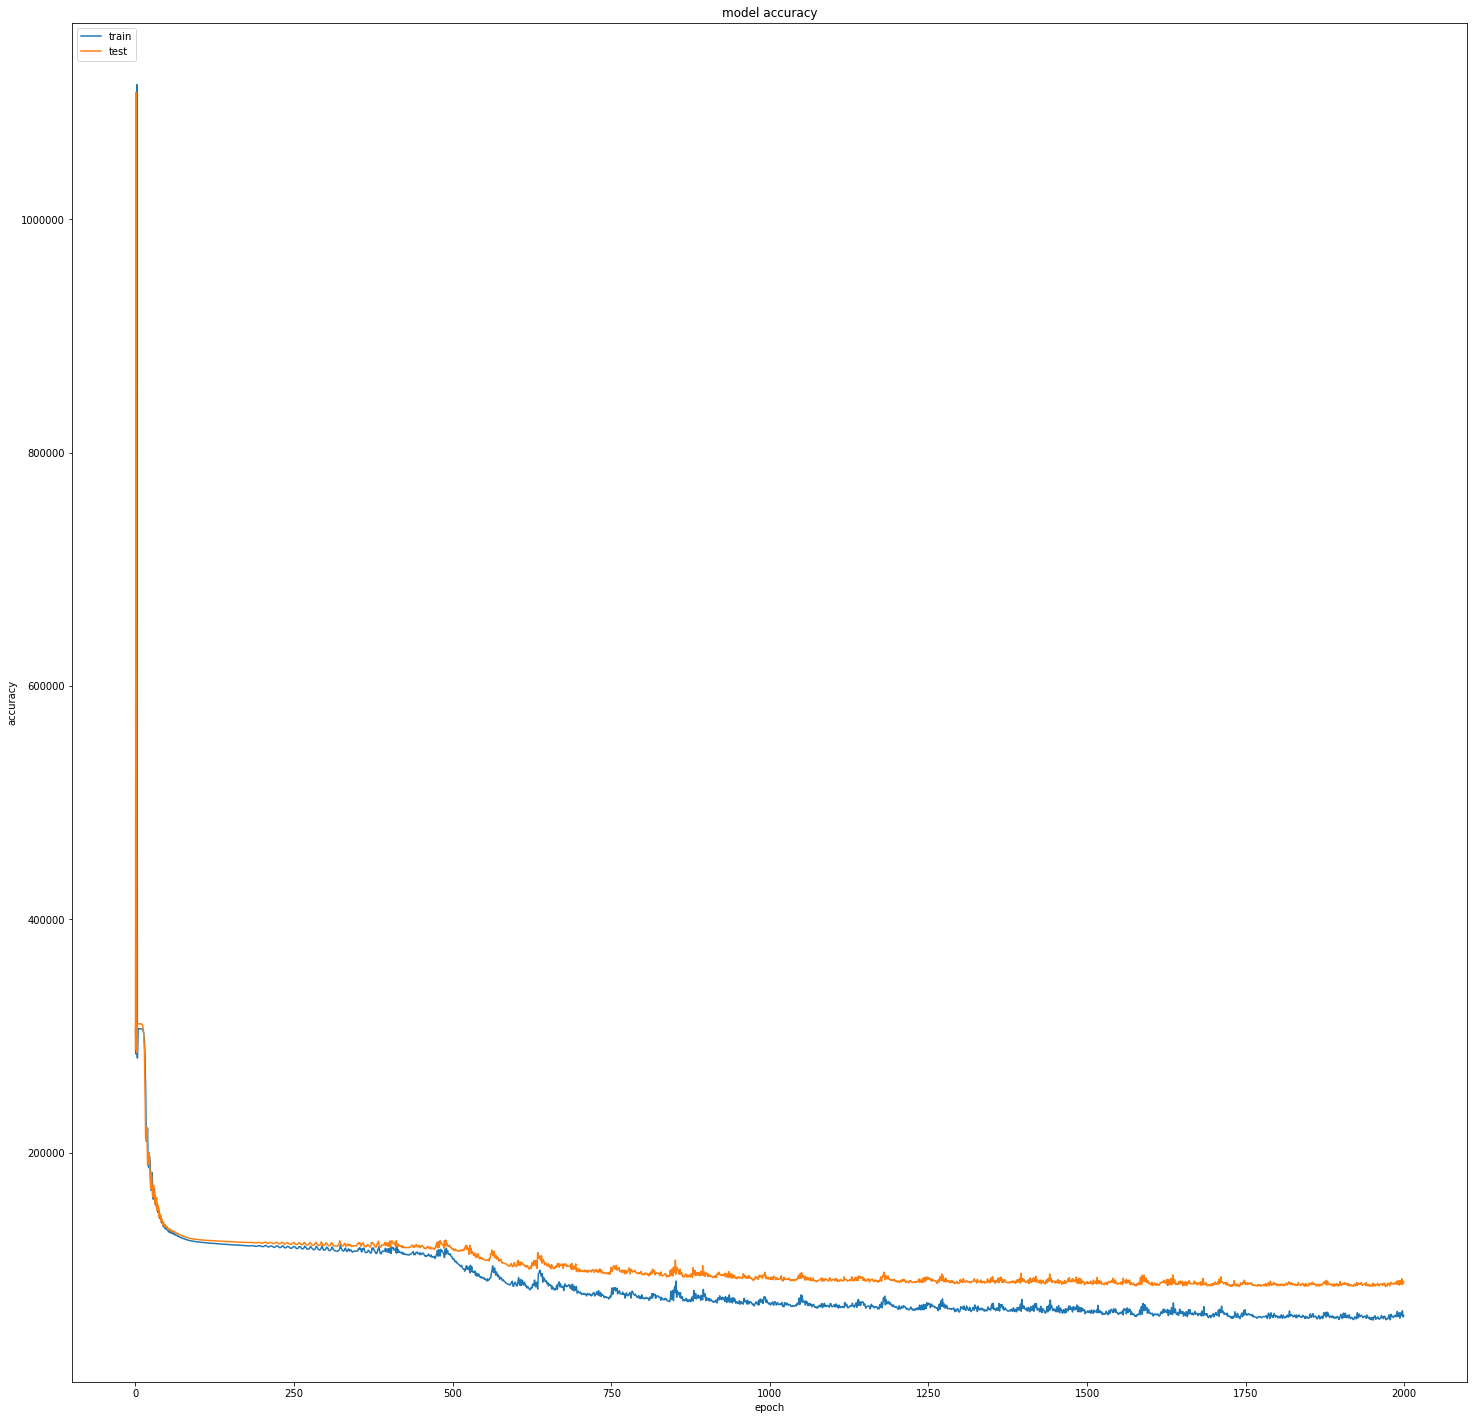

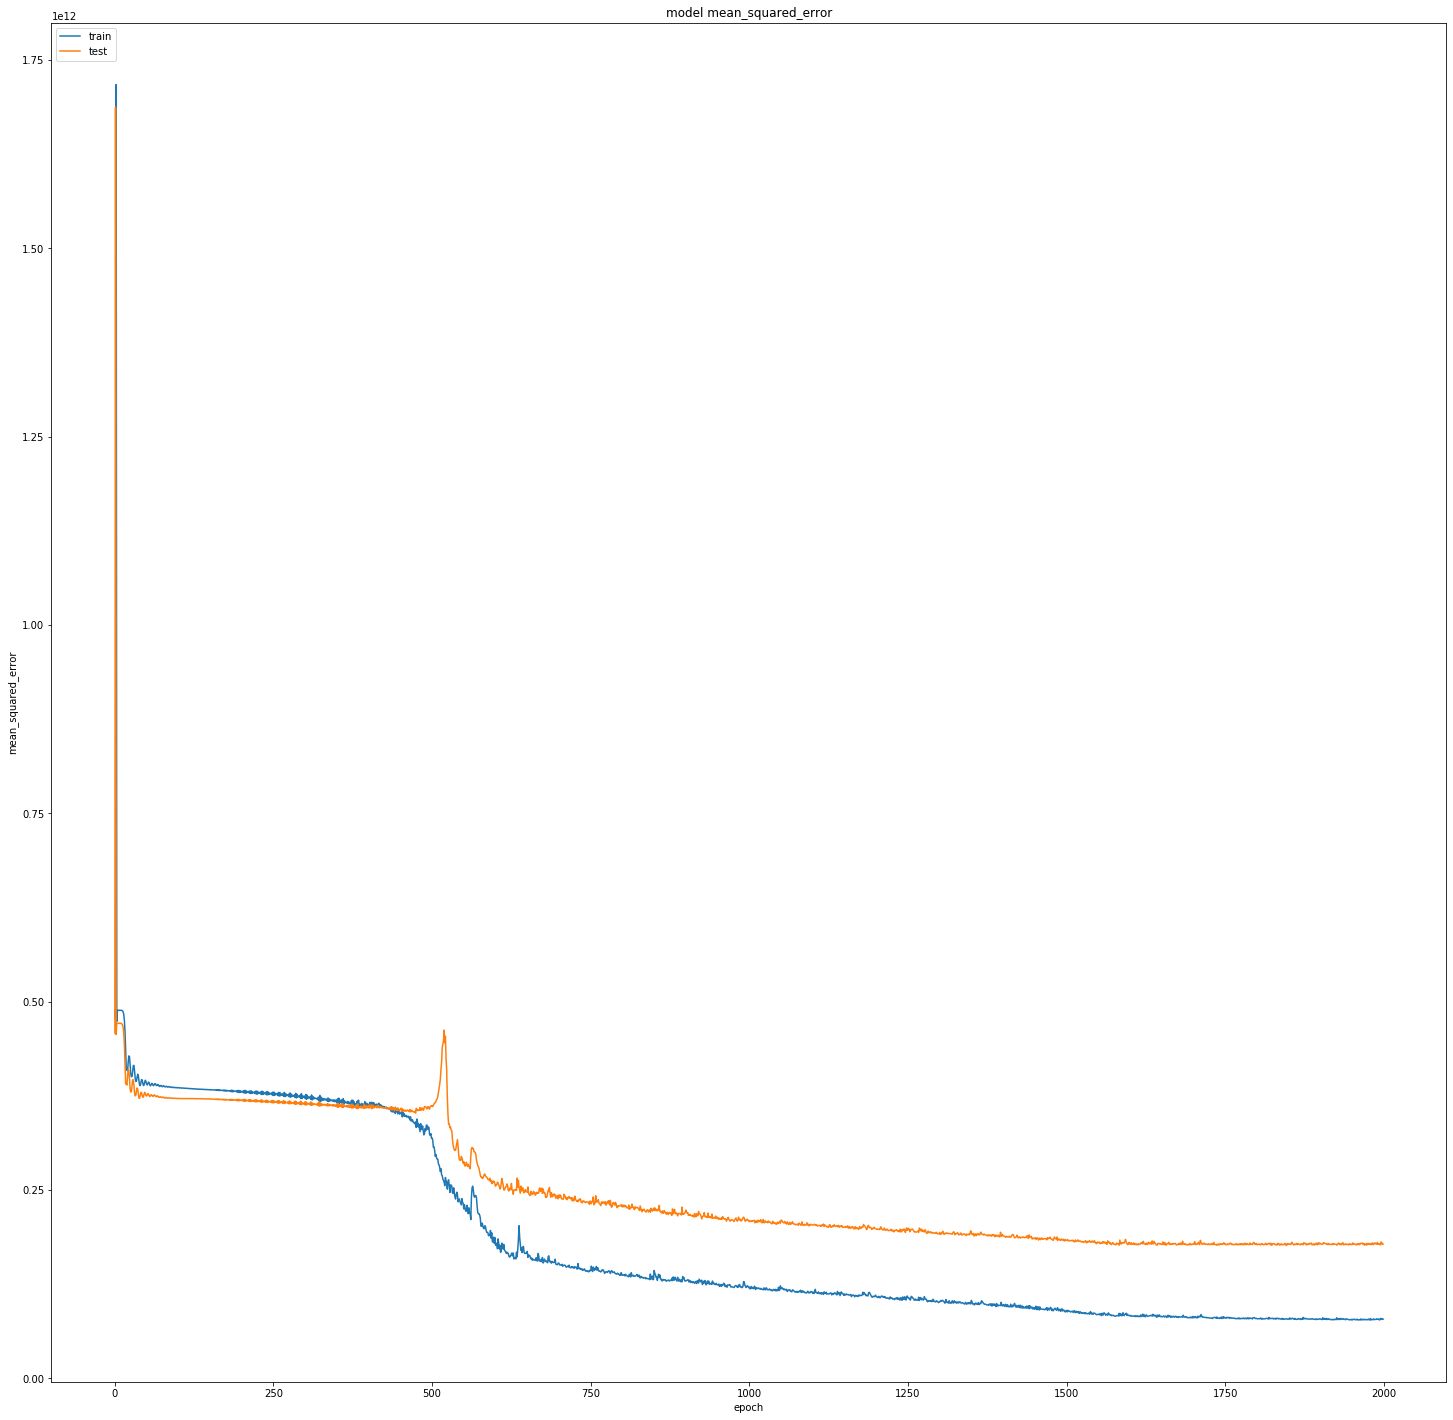

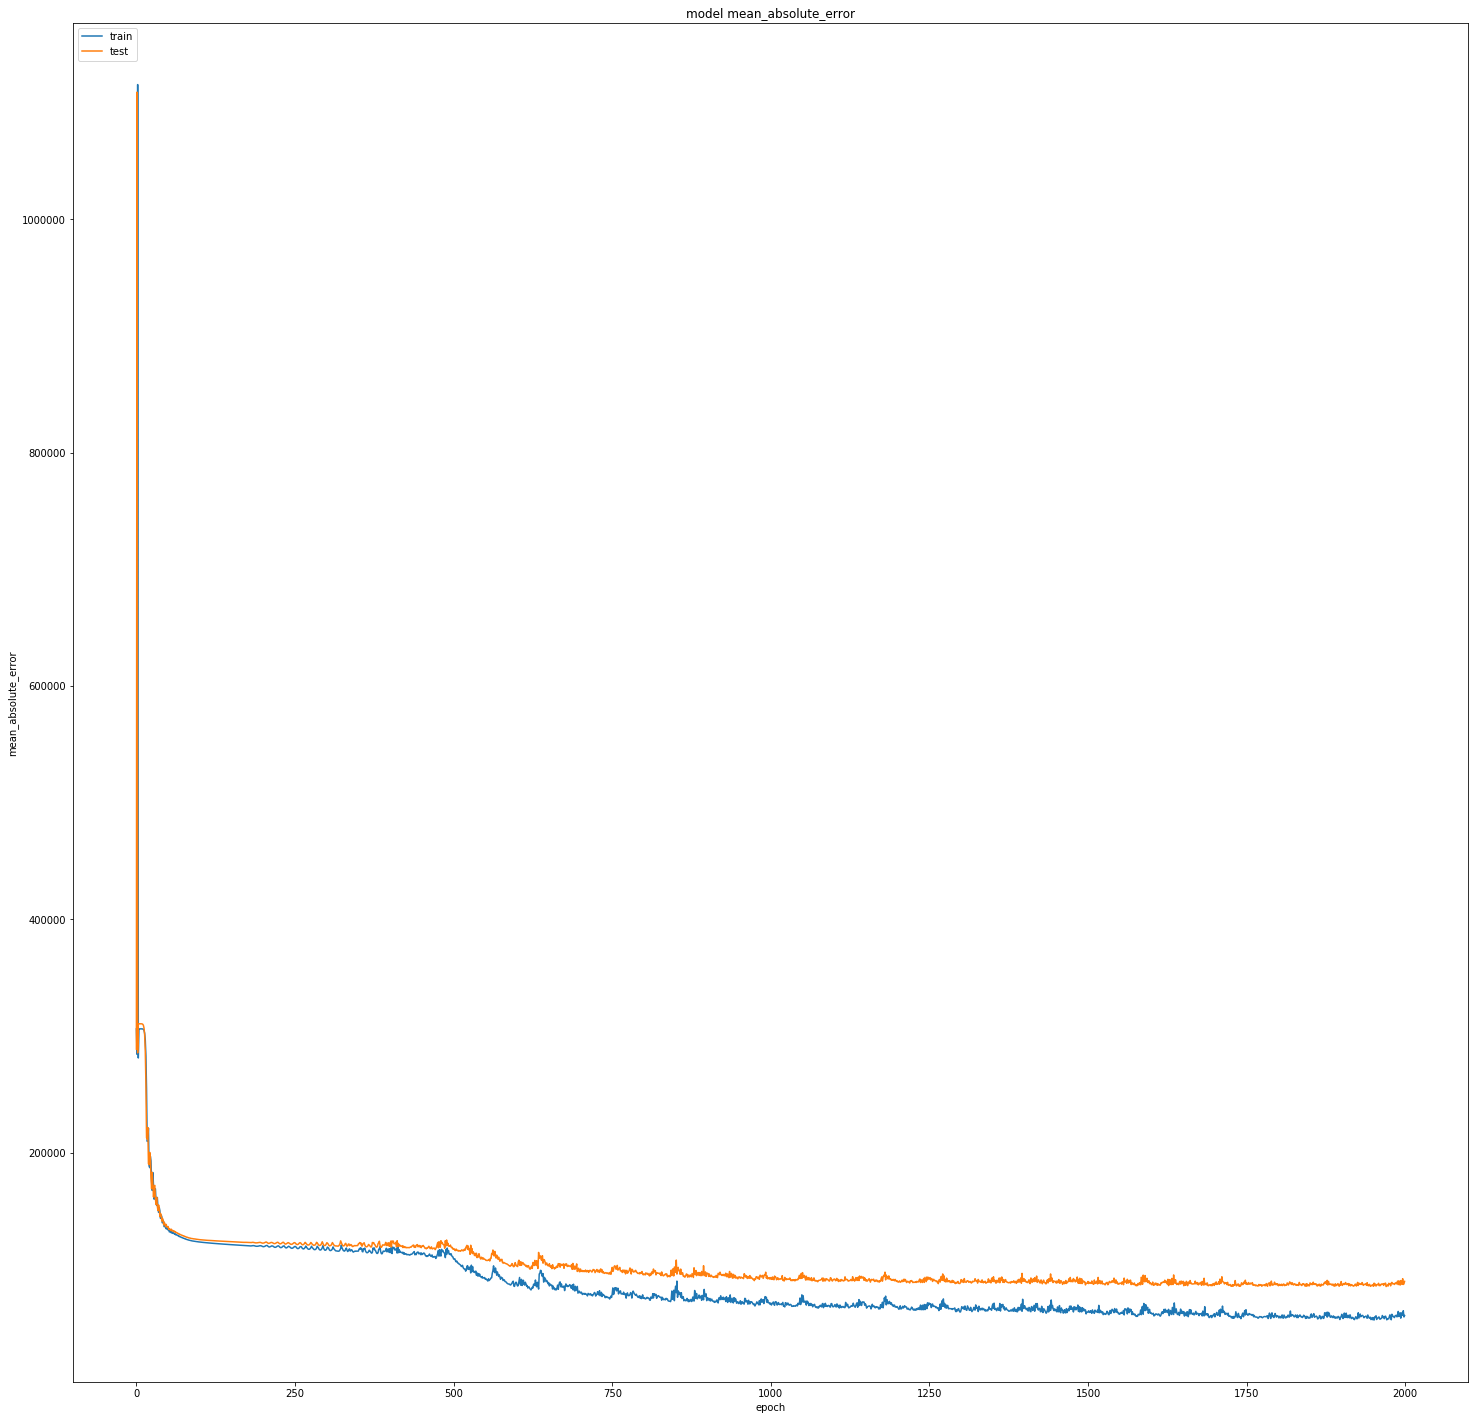

Median absolute error train: 27639.875
Median absolute error train: 35725.0234375
Mean absolute error train: 61926.67736042732
Mean absolute error train: 89704.58494186458


In [82]:
globalAnalysis('modelv4')

In [54]:
def prettify(model):
    summary = model.get_config()
    for val in summary['layers']:
        print("{} layer : {} units, {} activation ".format(val['class_name'], val['config']['units'], val['config']['activation']))

prettify(model)

Dense layer : 256 units, relu activation 
Dense layer : 512 units, relu activation 
Dense layer : 1024 units, relu activation 
Dense layer : 1024 units, relu activation 
Dense layer : 512 units, relu activation 
Dense layer : 256 units, relu activation 
Dense layer : 1 units, linear activation 


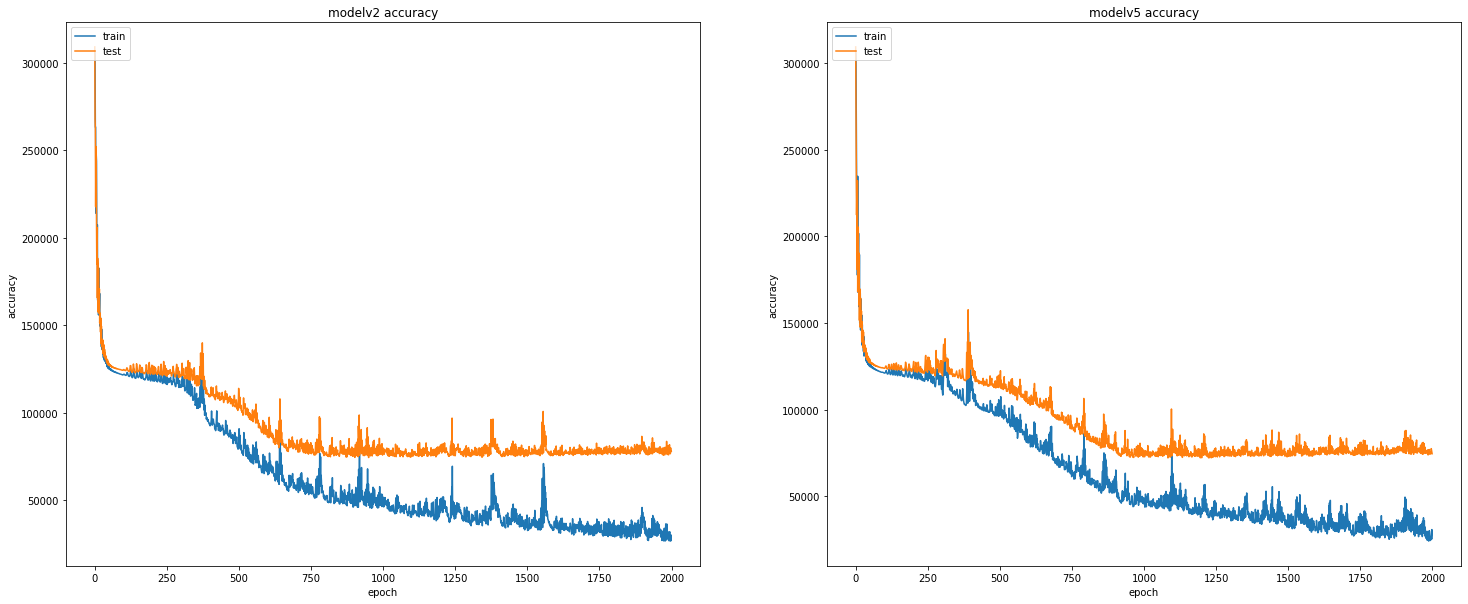

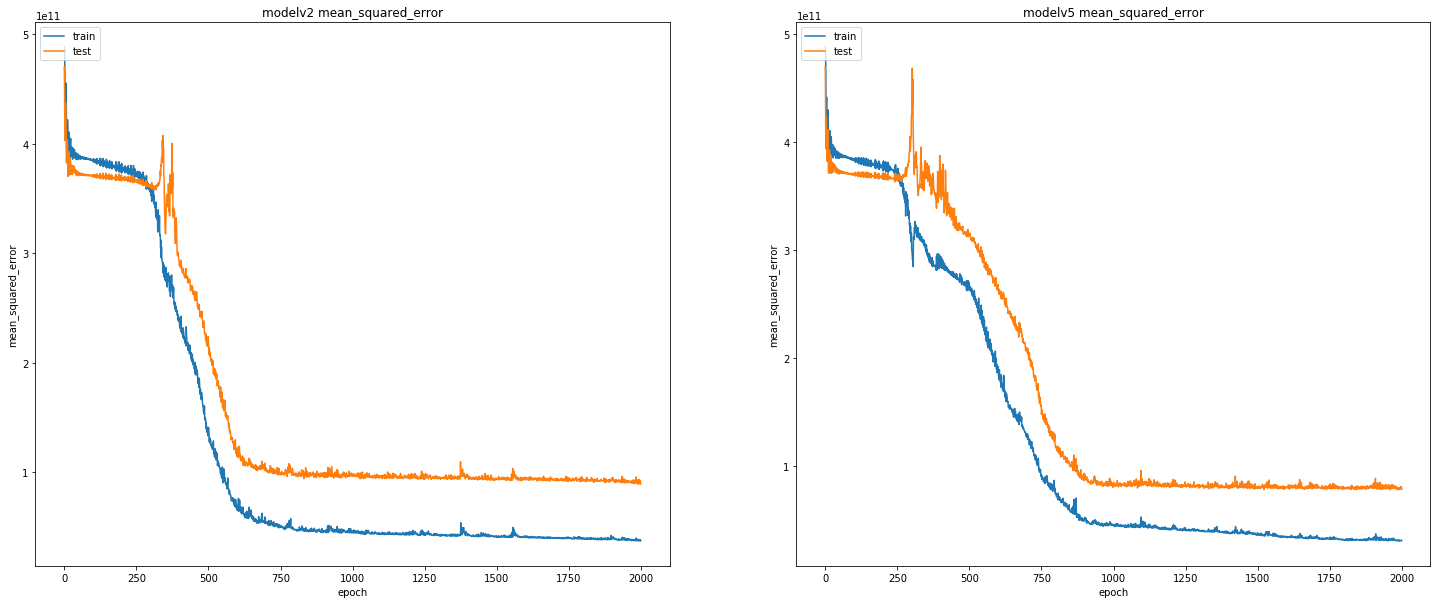

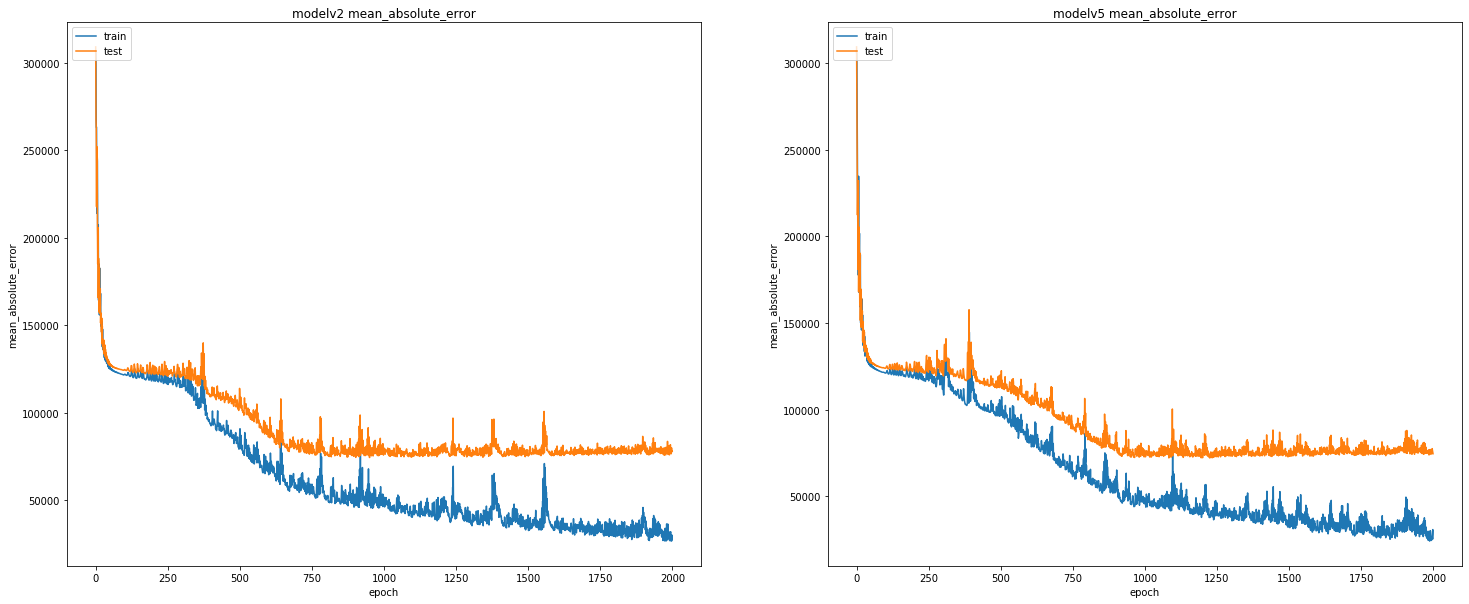

Median absolute error train: 
modelv2 14336.34375
modelv5 11763.34375
Median absolute error test: 
modelv2 36454.1796875
modelv5 35326.359375
Mean absolute error train: 
modelv2 31097.962719818956
modelv5 26835.89396834349
Mean absolute error test: 
modelv2 77961.95670731626
modelv5 74576.51077524298


In [106]:
compareTwoModel('modelv2','modelv5')

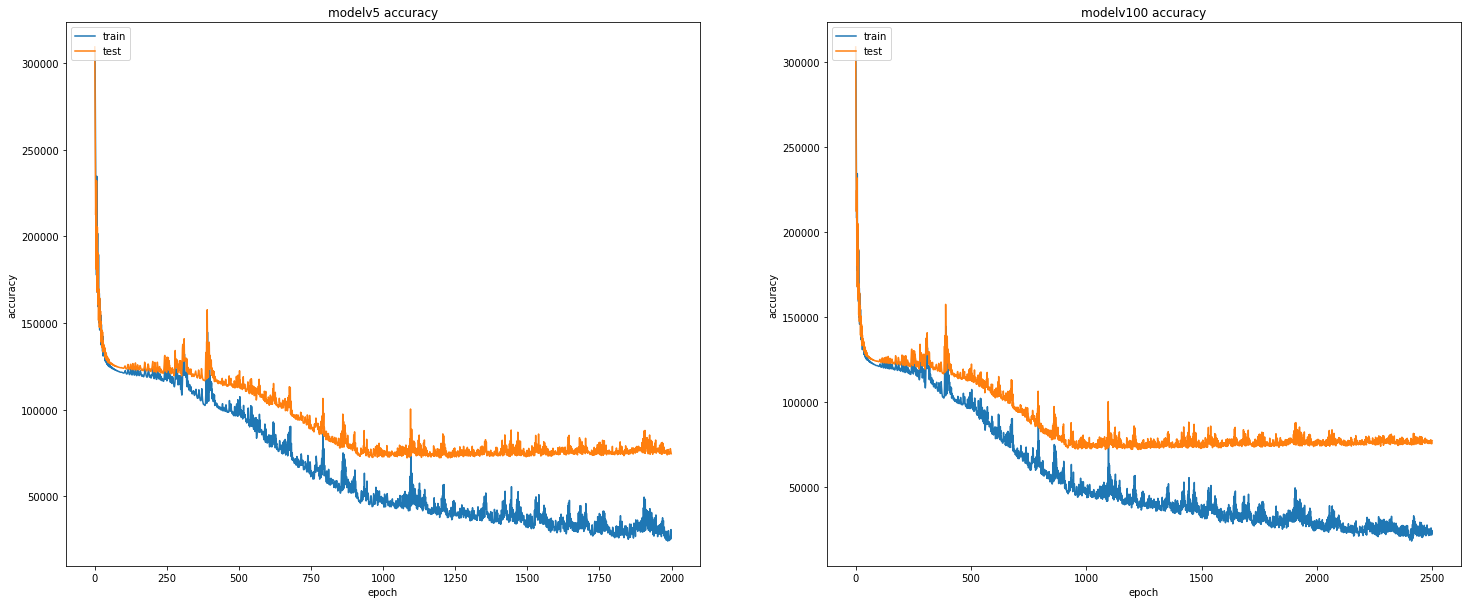

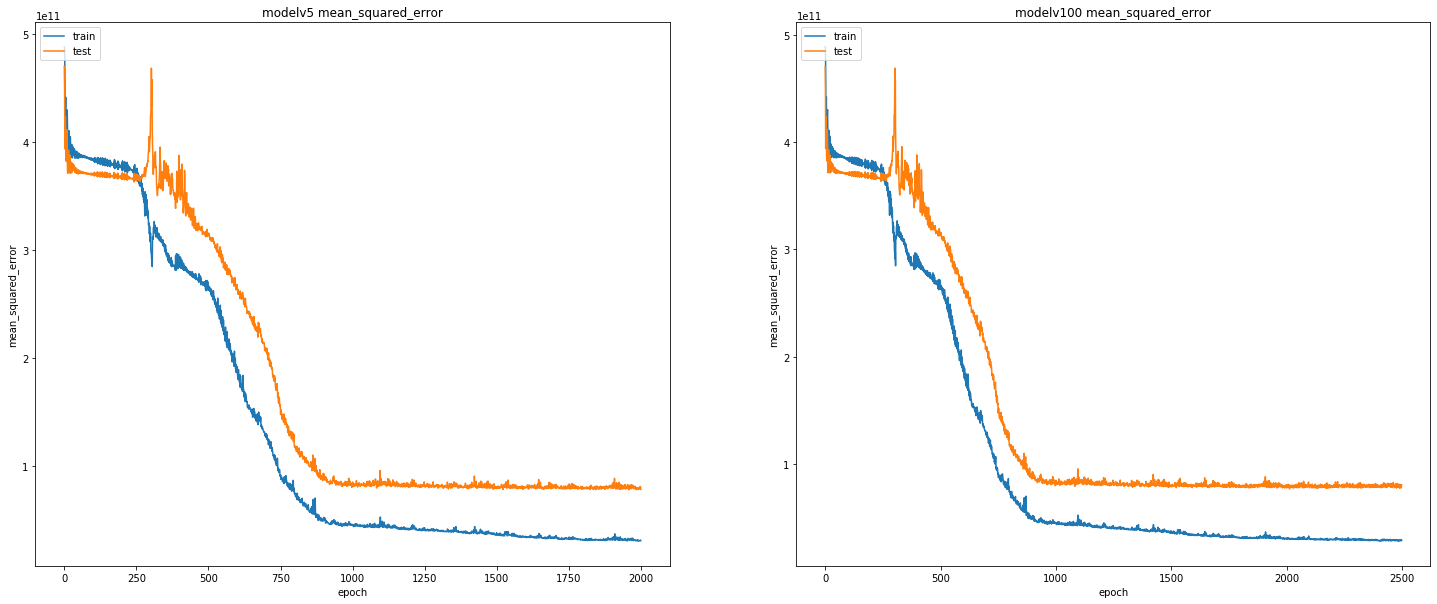

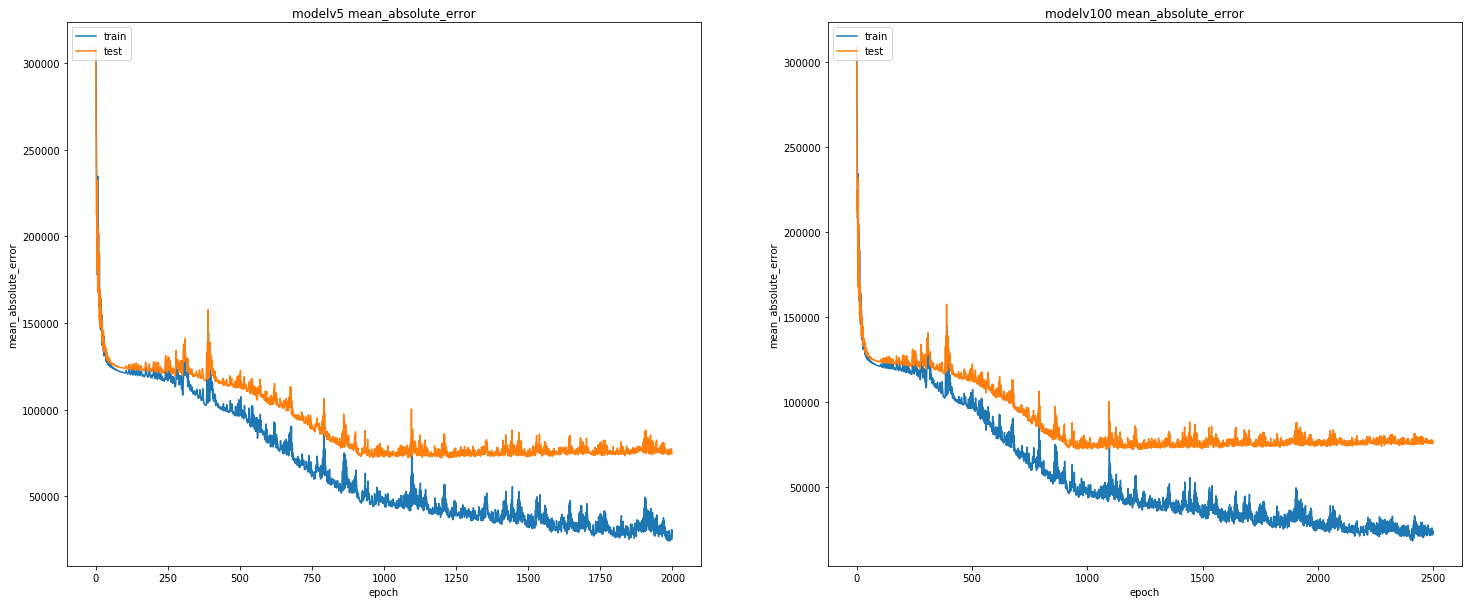

Median absolute error train: 
modelv5 11763.34375
modelv100 7590.2421875
Median absolute error test: 
modelv5 35326.359375
modelv100 37027.984375
Mean absolute error train: 
modelv5 26835.89396834349
modelv100 21431.932595891314
Mean absolute error test: 
modelv5 74576.51077524298
modelv100 77338.92063251267


In [107]:
compareTwoModel('modelv5','modelv100')